In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ParticleFilter.Tools import resample
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')

In [2]:
degraded_battery_Z = "./Battery_Data/degraded_battery_cycles/Battery_RNN_from_new_vpf_v1_part_7.mdl"
degraded_battery_Z_changed_Ecrit = "./Battery_Data/degraded_battery_cycles/Battery_RNN_from_new_vpf_change_Ecrit_v2_part_10.mdl"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
E_crit_old = 21879.133773481735
E_crit_new = 26267.160775850585

In [3]:
def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)


Current_min = -0.000520787
Current_max = 6.74372
SoC_max = 0.9999999904515033
SoC_min = 1.7066589027420198e-14

In [4]:
class RNNetwork(nn.Module):
    def __init__(self):
        super(RNNetwork, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        # SMC params
        self.f_mean = torch.Tensor([-8.131135726750027e-06])
        self.f_std = torch.Tensor([0.0002551068601502507])
        self.g_std = 0.011334095
        self.nu = torch.Tensor([1.0 / (self.g_std * np.sqrt(2 * np.pi))])

    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L)*torch.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(torch.exp(-beta) - torch.exp(-beta*torch.sqrt(SoC)))
    
    def predict_Ecrit(self, soc_init, current, E_crit=26267.160775850585):
        
        voltage = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc = soc_init.to(device, torch.float)
        
        I = torch.ones(1, 1) * current[0, 0]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, SoC_min, SoC_max)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z
        
        for t in range(current.shape[1]):

            # Predict SoC
            soc = soc - I*V/E_crit

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(1, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I*Z

            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]

        return voltage, soc_hist
            
        

    def forward(self, soc_init, current, voltage_measured, E_crit=26267.160775850585):
        first = True
        voltage = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc = soc_init.to(device, torch.float)
        N = soc_init.shape[0]

        I = torch.ones(N, 1) * current[0, 0]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, SoC_min, SoC_max)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z

        for t in range(current.shape[1]):

            # Predict SoC
            soc = soc - I*V/E_crit
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I*Z

            #SMC
            W = self.nu * torch.exp(-0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0))
            logW = torch.log(self.nu) - 0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0)

            max_logW = logW.max()
            loss_W = torch.exp(logW - max_logW)

            if not first:
                loss = loss + max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
            else:
                loss = max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
                first = False

            # Resampling
            soc, W = resample(soc, loss_W)

            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]

        return loss, voltage, soc_hist

In [5]:
vsmc = RNNetwork()
vsmc.load_state_dict(torch.load(degraded_battery_Z))
vsmc.to(device)

RNNetwork(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
)

In [6]:
test_discharge = "Battery_Data/degraded_battery_cycles/c2_test_discharge.p"
data = pickle.load(open(test_discharge, 'rb'), encoding='latin1')
fix_naming = {}
for name in data.keys():
    if name == "Current:":
        fix_naming[name[:-1]] = data[name]*-1
    else:
        fix_naming[name[:-1]] = data[name]
data = fix_naming
current_extended = np.concatenate((data['Current'], np.ones((1, 450))*data['Current'][0, -1]), 1)
current_extended = data['Current']

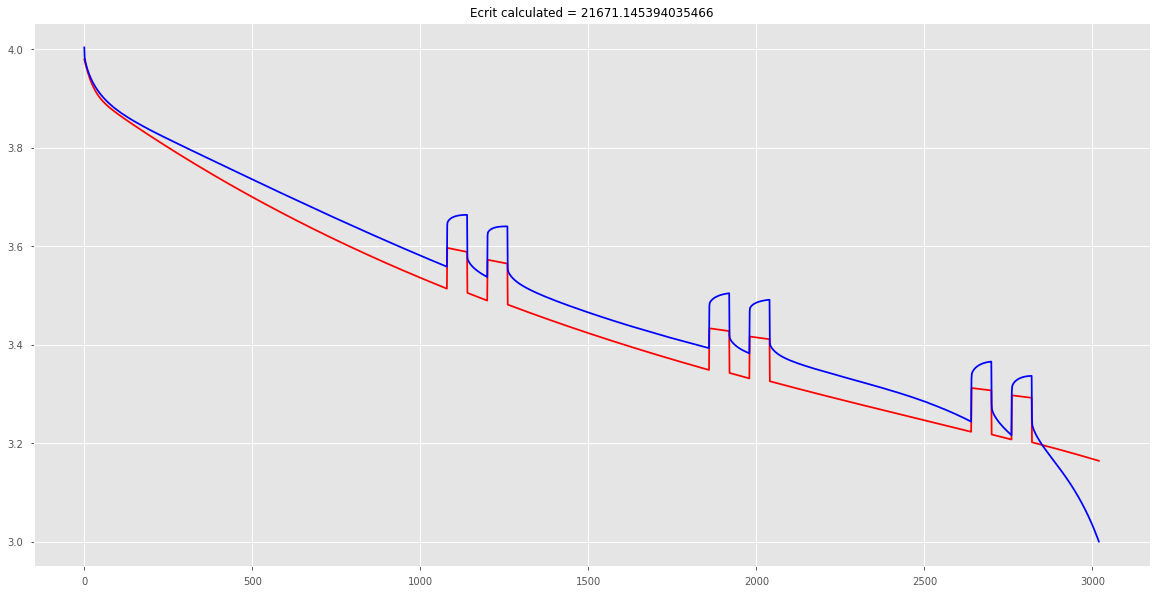

In [7]:
with torch.no_grad():
    state = torch.ones(1, 1) * 1.0
    voltage, soc_hist = vsmc.predict_Ecrit(state, current_extended)
    voltage = voltage.numpy()
    seconds = np.ones_like(np.array(current_extended)[0, :])
    new_Ecrit = np.sum(np.array(current_extended)[0, :]*seconds*voltage[0, :])
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure()
plt.title("Ecrit calculated = " + str(new_Ecrit))
plt.plot(voltage.T, 'r')
plt.plot(data['Voltage'].T, 'b')
plt.show()

In [8]:
# with torch.no_grad():
#     new_Ecrit, voltage_hist, I_hist, seconds_hist = vsmc.predict_Ecrit(discharge_rate=1.0)
# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.figure()
# plt.title("Ecrit calculated = " + str(new_Ecrit))
# plt.plot(voltage_hist)
# plt.show()